# Lending Club - Initial Data Exploration for Feasiblity as Demo Data 

I have done a quick exploration of the data below to vertify if the Lending Club Data is sufficient to cover most of the techniques required in the demo. 

In [4]:
library(tidyverse)
library(zoo)
library(arules)

## Loading Data
There are two data sets one for loans that are accepted and another for loans that are rejected. They are split because they have a different number of variables.

In [ ]:
#read in the zipped data from the kaggle data input
accepted_def <- read_csv(gzfile("C:/Users/smytmc/accepted_2007_to_2018Q3.csv.gz"));
rejected_def <- read_csv(gzfile("C:/Users/smytmc/rejected_2007_to_2018Q3.csv.gz"));

Parsed with column specification:
cols(
  .default = col_double(),
  id = col_integer(),
  member_id = col_character(),
  term = col_character(),
  grade = col_character(),
  sub_grade = col_character(),
  emp_title = col_character(),
  emp_length = col_character(),
  home_ownership = col_character(),
  verification_status = col_character(),
  issue_d = col_character(),
  loan_status = col_character(),
  pymnt_plan = col_character(),
  url = col_character(),
  desc = col_character(),
  purpose = col_character(),
  title = col_character(),
  zip_code = col_character(),
  addr_state = col_character(),
  earliest_cr_line = col_character(),
  initial_list_status = col_character()
  # ... with 31 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"31 parsing failures.
row # A tibble: 5 x 5 col      row col   expected   actual                    

In [7]:
#takes a look at the columns available in the dataset
glimpse(accepted_def)

Observations: 2,132,287
Variables: 151
$ id                                         <int> 93999587, 96219354, 9630...
$ member_id                                  <chr> NA, NA, NA, NA, NA, NA, ...
$ loan_amnt                                  <dbl> 19200, 7000, 12000, 6000...
$ funded_amnt                                <dbl> 19200, 7000, 12000, 6000...
$ funded_amnt_inv                            <dbl> 19200, 7000, 12000, 6000...
$ term                                       <chr> "36 months", "36 months"...
$ int_rate                                   <dbl> 13.99, 5.32, 16.99, 7.49...
$ installment                                <dbl> 656.12, 210.81, 427.78, ...
$ grade                                      <chr> "C", "A", "D", "A", "B",...
$ sub_grade                                  <chr> "C3", "A1", "D1", "A4", ...
$ emp_title                                  <chr> "Foreman", "Nurse", NA, ...
$ emp_length                                 <chr> "10+ years", "2 years", ...
$ home_owners

In [8]:
glimpse(rejected_def)

Observations: 25,054,319
Variables: 9
$ `Amount Requested`     <dbl> 13650, 10000, 40000, 20000, 6500, 5000, 8000...
$ `Application Date`     <date> 2017-04-01, 2017-04-01, 2017-04-01, 2017-04...
$ `Loan Title`           <chr> "Debt consolidation", "debt_consolidation", ...
$ Risk_Score             <dbl> 799, NA, NA, NA, NA, NA, NA, NA, NA, 551, NA...
$ `Debt-To-Income Ratio` <chr> "19.98%", "23.09%", "8.83%", "8.55%", "50.26...
$ `Zip Code`             <chr> "616xx", "234xx", "759xx", "110xx", "980xx",...
$ State                  <chr> "IL", "VA", "TX", "NY", "WA", "NC", "KS", "C...
$ `Employment Length`    <chr> "< 1 year", "< 1 year", "< 1 year", "< 1 yea...
$ `Policy Code`          <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


Taking a look at the rejected data a lot of information that is in the accepted data is missing. 

There are a few variables that are good targets for predictive modelling: 
1. application outcome (accepted or rejected) 
2. interest rate (*int_rate*)
3. grade of the loan (*grade*)
4. the loan status, if paid or defaulted (*loan_status*)

## Exploration
#### Categorical
There are too many variables to explore so we need to narrow it down to only a few. For now the exploration will be limited to the accepted loan data. 

In [9]:
# picking out cat variables to use
cat_var <- c("loan_status", "term", "grade", "emp_length", "home_ownership", 
                  "purpose", "addr_state")
# selects only the columns desired, then transforms data from wide to long
data_cat <- accepted_def %>% 
                select(cat_var) %>% 
                gather()
sample_n(data_cat, 5) ## just to preview the data
paste("number of rows of data", formatC(nrow(data_cat), big.mark=","))

key,value
term,36 months
purpose,debt_consolidation
purpose,debt_consolidation
loan_status,Current
loan_status,Current


[1] "number of rows of data 14,926,009"

In [10]:
sum_stats <- accepted_def %>% 
    select(loan.status=loan_status, term, grade, emp.length=emp_length, home.ownership=home_ownership, 
                  purpose, addr.state=addr_state) %>% 
    sample_n(1000) %>%
    summarise_all(funs(min, max, distinct=n_distinct))

sum_stats %>%
    gather() %>% 
    separate(key, c("stat", "var"), sep="_", extra="merge") %>%
    spread(var, value)

Warning message:
"package 'bindrcpp' was built under R version 3.5.1"

stat,distinct,max,min
addr.state,49,WV,AK
emp.length,12,NA,NA
grade,7,G,A
home.ownership,3,RENT,MORTGAGE
loan.status,7,Late (31-120 days),Charged Off
purpose,11,vacation,car
term,2,60 months,36 months


In [11]:
head(sum_stats)

loan.status_min,term_min,grade_min,emp.length_min,home.ownership_min,purpose_min,addr.state_min,loan.status_max,term_max,grade_max,...,home.ownership_max,purpose_max,addr.state_max,loan.status_distinct,term_distinct,grade_distinct,emp.length_distinct,home.ownership_distinct,purpose_distinct,addr.state_distinct
Charged Off,36 months,A,NA,MORTGAGE,car,AK,Late (31-120 days),60 months,G,...,RENT,vacation,WV,7,2,7,12,3,11,49


Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

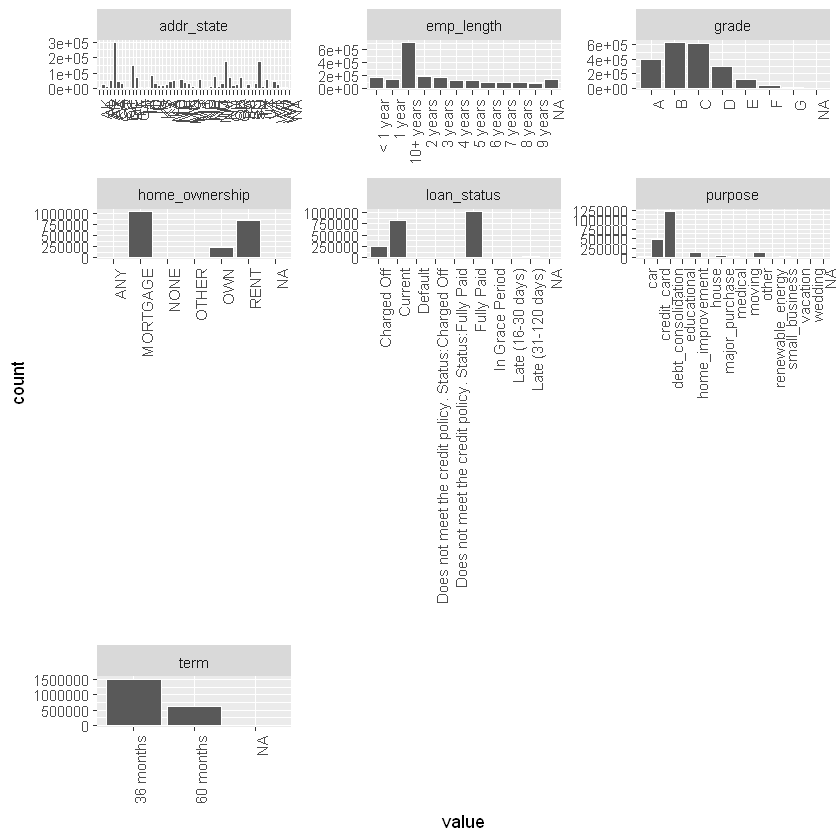

In [12]:
ggplot(data_cat, aes(value)) +
    facet_wrap(~key, scales="free") +
    geom_histogram(stat="count", color="white", size=0.1) +
    theme(axis.text.x=element_text(angle=90, hjust=1))

The data for grade looks good, so it can be used as a taget in a predictive model. On the other hand the count of "Default" in loan status looks to be very small.

In [13]:
accepted_def %>% 
    group_by(loan_status) %>% 
    summarise(count=n())

loan_status,count
Charged Off,254777
Current,822105
Default,32
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1988
Fully Paid,1011841
In Grace Period,12458
Late (16-30 days),5442
Late (31-120 days),22852
NA,31


So the number of loans with a status of "Default" is low, but according to the Lending Club [website definition](https://help.lendingclub.com/hc/en-us/articles/216127747) it is in fact a transitionary status, which then turns into "Charged Off" which is the final state for a loan where funds are not likely to be recovered.

There are plenty of loans that fall under "Charged Off" so loan_status can be used as a target for binary predictions.

#### Continuous
Doing the same for the continuos variables of interest.

In [14]:
cont_var <- c("loan_amnt", "funded_amnt", "int_rate", "installment", "annual_inc", "dti")
data_cont <- accepted_def %>% 
                    select(cont_var) %>% 
                    gather()
paste("number of rows of data", formatC(nrow(data_cont), big.mark=","))

[1] "number of rows of data 12,793,722"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 1664 rows containing non-finite values (stat_bin)."

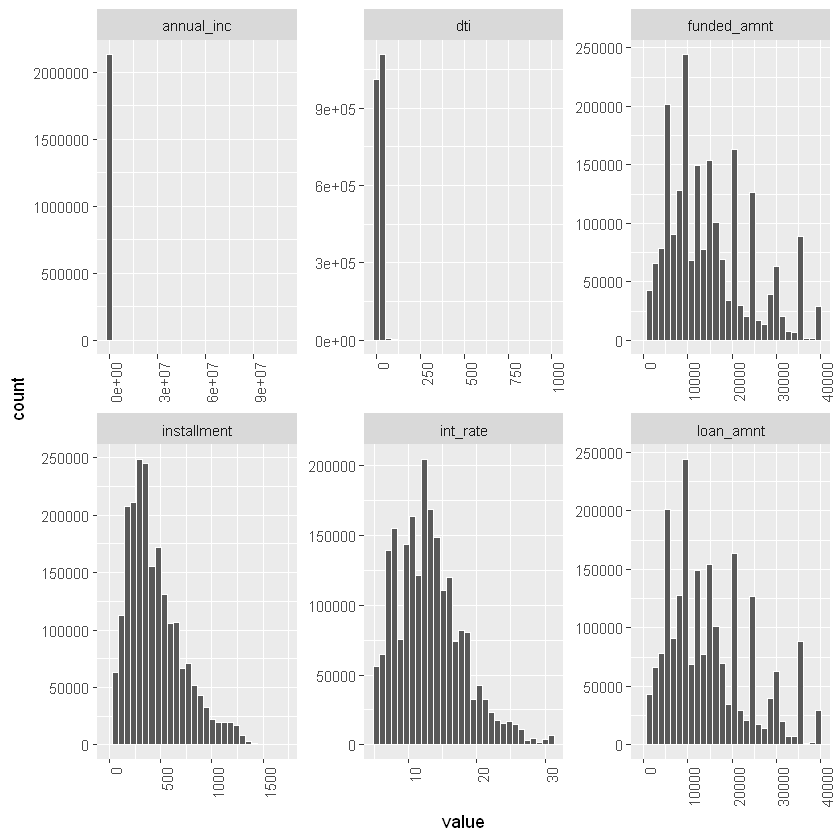

In [15]:
ggplot(data_cont, aes(value)) +
    facet_wrap(~key, scales="free") +
    geom_histogram(color="white", size=0.1) +
    theme(axis.text.x=element_text(angle=90, hjust=1))

For a continuos variable that can be predicted the interest rate (int_rate) looks like a good candidate, since we would want to be able to come up with what rate to charge depending on risk.

## Visualisations
There are quite a few different variables that would make good visualisations and dashboards. 
Below is a quick plot of grade seperated into subgrades, as a possible idea of some of the visualisations that can be used for VA. For example an isurance company would be interested in the portfolio of loans and the exposure to risk. 

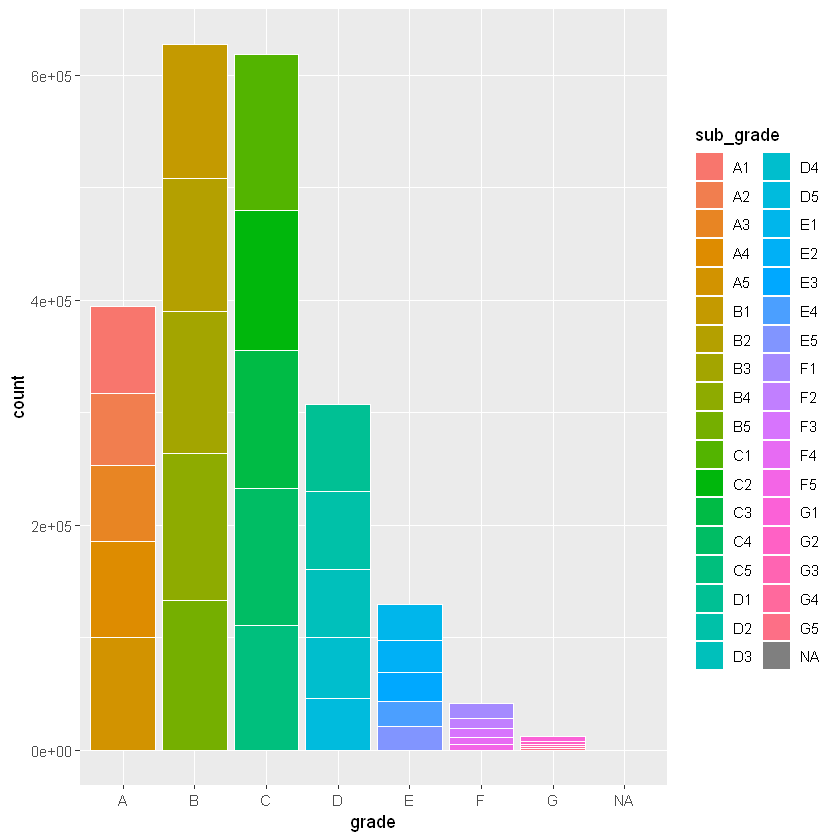

In [16]:
ggplot(accepted_def, aes(grade, fill=sub_grade)) +
    geom_bar(stat="count", color="white", size=0.25)

## Time series
There is some time series data, though dates are month-year (e.g. Apr-2008) with no days.

In [17]:
# gets total amount funded by date
amount_date <- accepted_def %>% 
                    group_by(issue_d) %>%
                    summarise(total=sum(funded_amnt))
# converts string to date format
amount_date["issue_d"] <- as.Date(as.yearmon(amount_date$issue_d, "%b-%Y")) 
head(amount_date, 3)

issue_d,total
2008-04-01,1811025
2009-04-01,3071350
2010-04-01,9510575


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (position_stack)."

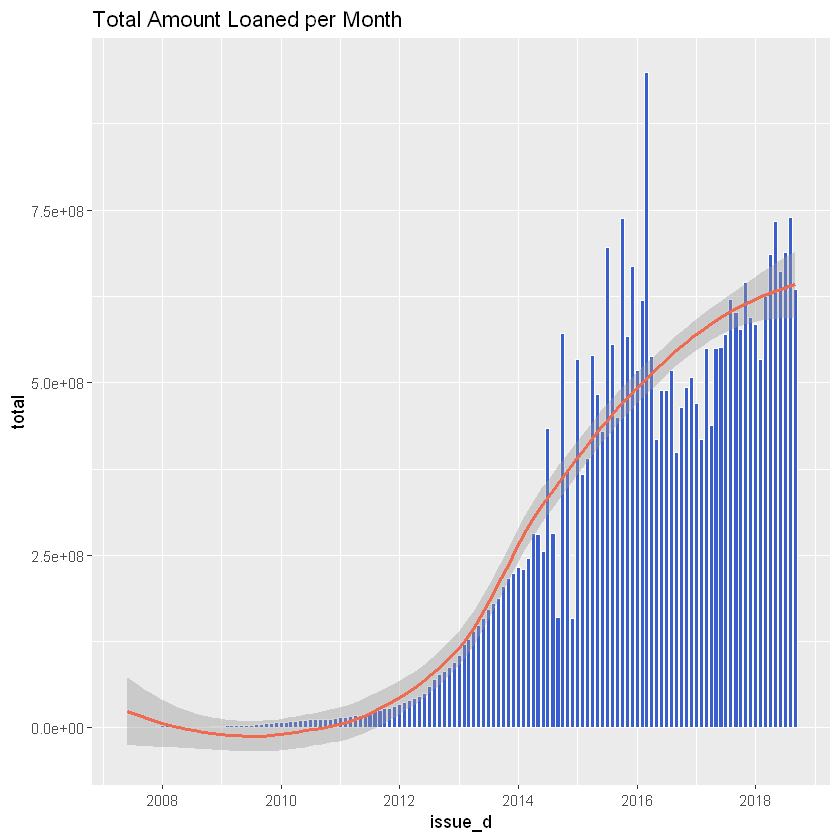

In [18]:
ggplot(amount_date, aes(issue_d, total)) +
    geom_bar(stat="identity", fill="royalblue3", color="white", size=0.1) + 
    geom_smooth(color="coral2") +
    ggtitle("Total Amount Loaned per Month")

## Association Analysis
One possible associaiton analysis is between the differnet grades of loans and the outcome of the loan, e.g. is grade linked to if it becomes fully paid or charged off.

In [20]:
accepted_def2 <- accepted_def
# only takes into account loans which are not current since current has yet to reach an outcome. 
association_data <- accepted_def2 %>% 
                        select(grade, loan_status) %>% 
                        filter(loan_status != "Current")
# performs associaiton analysis where lhs rule is a grade
association <- apriori(association_data, parameter=list(supp=0.01, conf=0.1), 
                       appearance=list(lhs=paste("grade=", unique(association_data$grade), sep="")))

Warning message:
"Column(s) 1, 2 not logical or factor. Applying default discretization (see '? discretizeDF')."

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 13101 

set item appearances ...[7 item(s)] done [0.00s].
set transactions ...[15 item(s), 1310151 transaction(s)] done [0.23s].
sorting and recoding items ... [9 item(s)] done [0.02s].
creating transaction tree ... done [0.52s].
checking subsets of size 1 2 done [0.00s].
writing ... [13 rule(s)] done [0.00s].
creating S4 object  ... done [0.14s].


In [21]:
association <- sort(association, by="confidence", decreasing=TRUE)
inspect(association)

     lhs          rhs                       support    confidence lift     
[1]  {grade=A} => {loan_status=Fully Paid}  0.15689031 0.9273797  1.2007889
[2]  {grade=B} => {loan_status=Fully Paid}  0.24380091 0.8441182  1.0929803
[3]  {}        => {loan_status=Fully Paid}  0.77230869 0.7723087  1.0000000
[4]  {grade=C} => {loan_status=Fully Paid}  0.21254420 0.7443220  0.9637623
[5]  {grade=D} => {loan_status=Fully Paid}  0.10091356 0.6614999  0.8565227
[6]  {grade=E} => {loan_status=Fully Paid}  0.04186235 0.5829100  0.7547629
[7]  {grade=F} => {loan_status=Fully Paid}  0.01294049 0.5205723  0.6740470
[8]  {grade=F} => {loan_status=Charged Off} 0.01070793 0.4307603  2.2151175
[9]  {grade=E} => {loan_status=Charged Off} 0.02647863 0.3687002  1.8959832
[10] {grade=D} => {loan_status=Charged Off} 0.04412926 0.2892724  1.4875380
[11] {grade=C} => {loan_status=Charged Off} 0.06170052 0.2160730  1.1111215
[12] {}        => {loan_status=Charged Off} 0.19446384 0.1944638  1.0000000
[13] {grade=

From the results of the asssociation analysis there is a link between the grade of the loan the eventual outcome, e.g. grade A loans is more strongly associated with being fully paid compared to grade E. Not the most interesting of association analysis, but it is something.

#### Clustering
So far I haven't found anything that looks good for clustering the data, but some data like age can be fabricated and added to the data.

Warning message in log(debt_to_income):
"NaNs produced"Warning message:
"Removed 329 rows containing missing values (geom_point)."

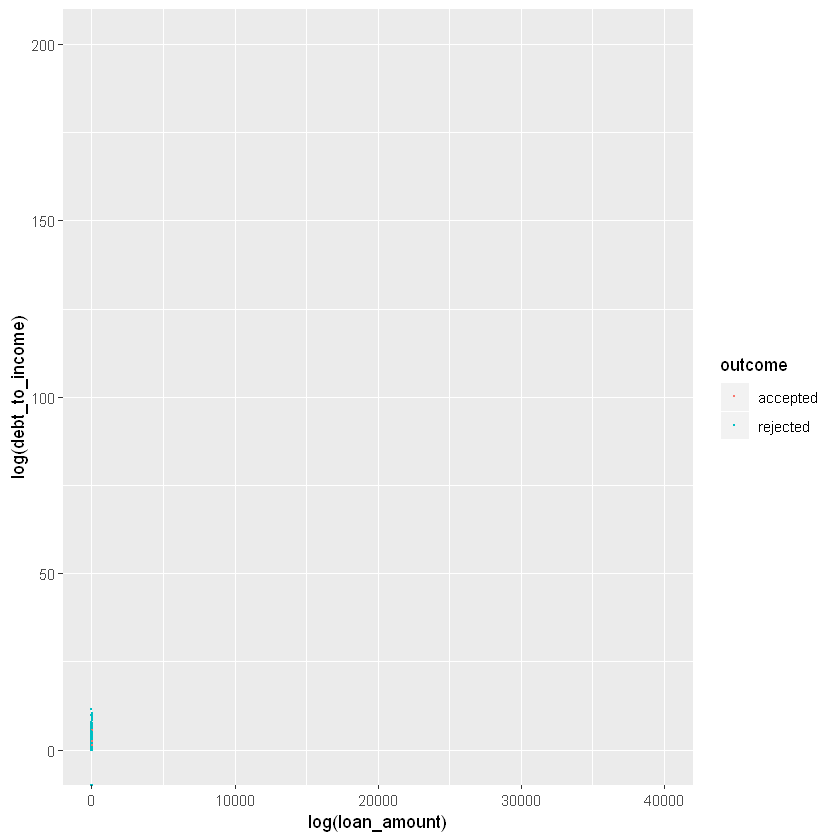

In [22]:
rejected <- rejected_def %>% 
                select(`Amount Requested`, `Debt-To-Income Ratio`) %>%
                drop_na() %>%
                mutate("rejected")
colnames(rejected) <- c("loan_amount", "debt_to_income", "outcome")
rejected[,"debt_to_income"] <- map(rejected[,"debt_to_income"], parse_number)

accepted <- accepted_def %>% 
                select(loan_amnt, dti) %>%
                drop_na() %>%
                mutate("accepted")
colnames(accepted) <- c("loan_amount", "debt_to_income", "outcome")

loan_outcome <- rbind(rejected, accepted)
ggplot(sample_n(loan_outcome, 5000), aes(log(loan_amount), log(debt_to_income), color=outcome)) + 
    geom_point(size=0.25) +
    ylim(0, 200) +
    xlim(0, 40000)

#### Multiple Loans
Attempt to find individuals with multiple loans. As there are no unique IDs for individuals, it is necessary to use common variables to identify the same individuals. There are only three variables that are likely to remain the same: job title, zip code and earliest credit line. 

In [ ]:
multi_loan <- accepted_def %>%
                select(emp_title, zip_code, earliest_cr_line) %>%
                na.omit() %>%
                group_by(emp_title, zip_code, earliest_cr_line) %>%
                summarise(count = n()) %>%
                arrange(desc(count))
head(multi_loan, 10)

The variables are too general making it difficult to tell which are unique individuals. For example with a loan term of 3 or 5 years it is unlikely that somebody has taken out 7 loans within 10 years, and it more likely that there is overlap occuring. 

#### Age proxy
There are a few metrics that might act as a proxy for the age of the individual: the length of time they have had credit, zip code mean age, length of time in employment. 

Employment caterogy ends at 10+ years, which is also the mode, so that would not work as a proxy. 

Census data can be found and population age mean by zip code can be used, assuming even uptake of Lending Club amongst all age demographics.

In this case the **credit_years** is determined by taking the **loan issue date** (issue_d) and subtracting by **earliest credit line** (earliest_cr_line). This would work as a proxy as long as the underlying assumption that everybody gets their first line of credit around the same age is true. 

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Removed 51 rows containing non-finite values (stat_count)."


	Welch Two Sample t-test

data:  credit_years by loan_status
t = -37.546, df = 393870, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6543612 -0.5894325
sample estimates:
mean in group Charged Off  mean in group Fully Paid 
                  15.7480                   16.3699 


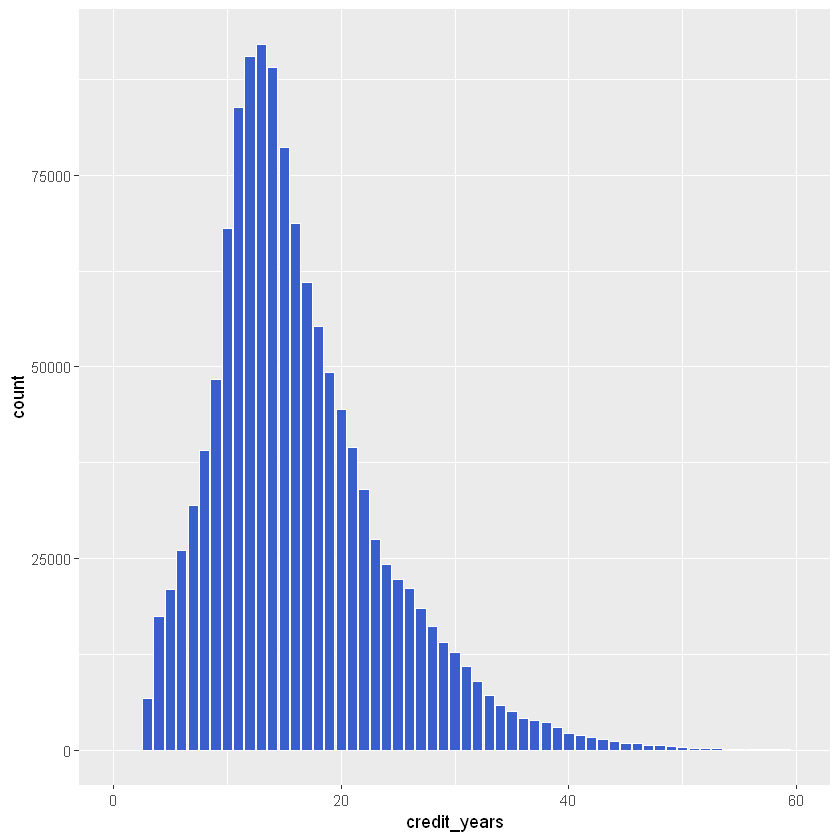

In [24]:
# takes the value from issue date and converts it to year month format, turns it into a date, takes the number of days between the two date times
# divides by days in year to get number of years, rounds the value, converts to numeric, and adds to the data.
accepted_def_age <- accepted_def %>% 
                        mutate(credit_years = as.numeric(round(difftime(as.Date(as.yearmon(accepted_def[["issue_d"]], "%b-%Y")), 
                                                             as.Date(as.yearmon(accepted_def[["earliest_cr_line"]], "%b-%Y")), units="days")/365.25)))
credit_years_data <- accepted_def_age %>% 
                        select(loan_status, credit_years) %>% 
                        filter(loan_status %in% c("Charged Off", "Fully Paid")) %>%
                        na.omit()
ggplot(credit_years_data, aes(x=credit_years)) + 
    geom_histogram(stat="count", fill="royalblue3", color="white", size=0.1) +
    xlim(0, 60)
t.test(credit_years~loan_status, data=credit_anova_data)

Thus concludes the initial exploration. Identified are a few good avenues to explore when it comes to modelling the data.
Overall easibility of producing a predictive model from this data set for demo purposes is decent.